Import Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

Core functions

In [10]:
def load_images_from_folder(folder_path, image_size=(64,64)):
    images = []
    labels = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    
    print(f"📂 Loading images from: {folder_path}")
    print(f"🏷️  Found classes: {class_names}")
    
    total_images = 0
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"  📊 {class_name}: {len(image_files)} images")
        
        for filename in image_files:
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                images.append(np.array(img).flatten())
                labels.append(class_name)
                total_images += 1
            except Exception as e:
                print(f"❌ Error loading {img_path}: {e}")
    
    print(f"✅ Successfully loaded {total_images} images")
    return np.array(images), np.array(labels)

def predict_image(image_path, model, label_encoder, image_size=(64,64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img).flatten().reshape(1, -1)
    pred = model.predict(img_array)
    predicted_class = label_encoder.inverse_transform(pred)[0]
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(img_array)[0]
        confidence = np.max(probabilities)
        return predicted_class, confidence, probabilities
    else:
        return predicted_class, None, None

def show_sample_images(folder, classes, n=3):
    
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue
            
        images = [f for f in os.listdir(cls_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:n]
        
        if not images:
            continue
            
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'🍎 Sample {cls.title()} Images', fontsize=14, fontweight='bold')
        
        for i, img_name in enumerate(images):
            try:
                img = Image.open(os.path.join(cls_path, img_name))
                plt.subplot(1, n, i+1)
                plt.imshow(img)
                plt.title(f'{cls}\n{img_name}', fontsize=10)
                plt.axis('off')
            except Exception as e:
                print(f"❌ Error displaying {img_name}: {e}")
        
        plt.tight_layout()
        plt.show()

Load data

In [11]:
train_dir = '../data/train'
test_dir = '../data/test'

print("🚀 LOADING DATASET")
print("=" * 50)

X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)

print(f"\n📊 DATASET SUMMARY:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimensions: {X_train.shape[1]} (64x64x3 flattened)")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print(f"Classes: {list(le.classes_)}")

🚀 LOADING DATASET
📂 Loading images from: ../data/train
🏷️  Found classes: ['apple', 'banana', 'orange']
  📊 apple: 440 images
  📊 banana: 233 images
  📊 orange: 479 images
✅ Successfully loaded 1152 images
📂 Loading images from: ../data/test
🏷️  Found classes: ['apple', 'banana', 'orange']
  📊 apple: 146 images
  📊 banana: 77 images
  📊 orange: 160 images
✅ Successfully loaded 383 images

📊 DATASET SUMMARY:
Training samples: 1152
Test samples: 383
Feature dimensions: 12288 (64x64x3 flattened)
Classes: [np.str_('apple'), np.str_('banana'), np.str_('orange')]


Dataset analysis and visualization 

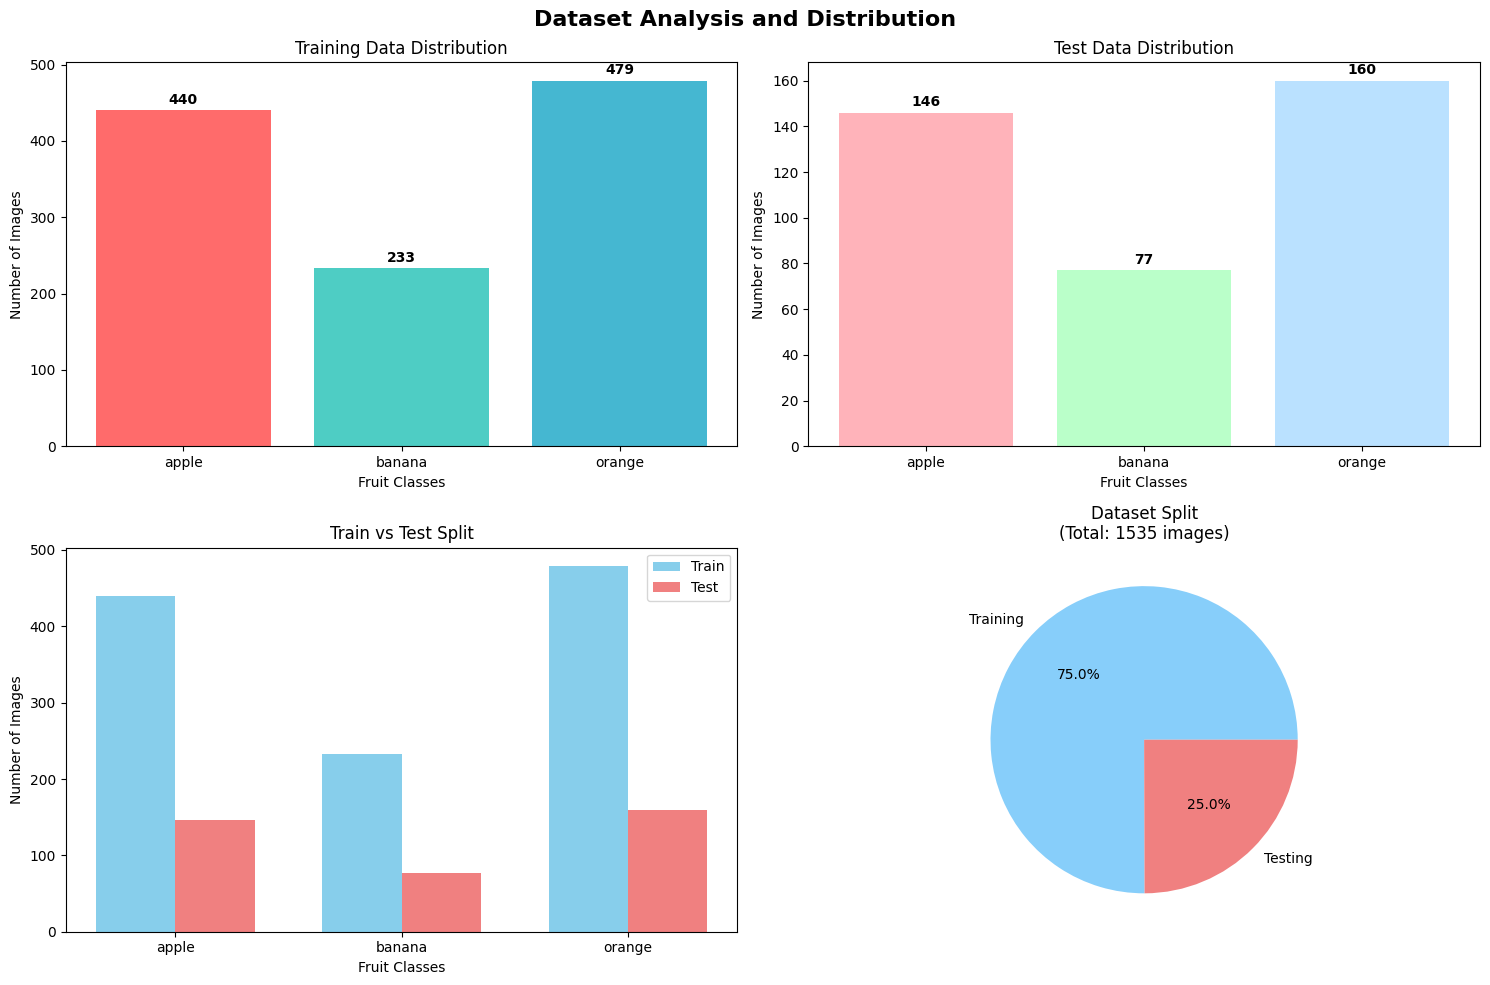

DATASET SUMMARY
Total training images: 1152
Total test images: 383
Number of classes: 3
Classes: ['apple', 'banana', 'orange']

Per-class breakdown:
  apple: 440 train, 146 test (total: 586)
  banana: 233 train, 77 test (total: 310)
  orange: 479 train, 160 test (total: 639)


In [13]:
def analyze_dataset_distribution(train_dir, test_dir):

    train_counts = {}
    test_counts = {}
    
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            train_counts[class_name] = len([f for f in os.listdir(class_path) 
                                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            test_counts[class_name] = len([f for f in os.listdir(class_path) 
                                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dataset Analysis and Distribution', fontsize=16, fontweight='bold')

    classes = list(train_counts.keys())
    train_values = list(train_counts.values())
    
    axes[0, 0].bar(classes, train_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0, 0].set_title('Training Data Distribution')
    axes[0, 0].set_xlabel('Fruit Classes')
    axes[0, 0].set_ylabel('Number of Images')

    for i, v in enumerate(train_values):
        axes[0, 0].text(i, v + max(train_values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

    test_values = [test_counts.get(cls, 0) for cls in classes]
    axes[0, 1].bar(classes, test_values, color=['#FFB3BA', '#BAFFC9', '#BAE1FF', '#FFFFBA'])
    axes[0, 1].set_title('Test Data Distribution')
    axes[0, 1].set_xlabel('Fruit Classes')
    axes[0, 1].set_ylabel('Number of Images')
    
    for i, v in enumerate(test_values):
        axes[0, 1].text(i, v + max(test_values)*0.01 if test_values else 0, str(v), ha='center', va='bottom', fontweight='bold')

    x = np.arange(len(classes))
    width = 0.35
    axes[1, 0].bar(x - width/2, train_values, width, label='Train', color='skyblue')
    axes[1, 0].bar(x + width/2, test_values, width, label='Test', color='lightcoral')
    axes[1, 0].set_title('Train vs Test Split')
    axes[1, 0].set_xlabel('Fruit Classes')
    axes[1, 0].set_ylabel('Number of Images')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(classes)
    axes[1, 0].legend()

    total_train = sum(train_values)
    total_test = sum(test_values)
    
    axes[1, 1].pie([total_train, total_test], labels=['Training', 'Testing'], 
                   autopct='%1.1f%%', colors=['lightskyblue', 'lightcoral'])
    axes[1, 1].set_title(f'Dataset Split\n(Total: {total_train + total_test} images)')
    
    plt.tight_layout()
    plt.show()

    print("DATASET SUMMARY")
    print("=" * 40)
    print(f"Total training images: {total_train}")
    print(f"Total test images: {total_test}")
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes}")
    print("\nPer-class breakdown:")
    for cls in classes:
        train_count = train_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        total_cls = train_count + test_count
        print(f"  {cls}: {train_count} train, {test_count} test (total: {total_cls})")

analyze_dataset_distribution(train_dir, test_dir)

Feature analysis

In [14]:
def analyze_image_features(data_dir, classes, sample_size=50):

    print("🔬 FEATURE ANALYSIS - 3 Key Features")
    print("=" * 50)
    
    feature_data = []
    
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        sampled_files = image_files[:min(sample_size, len(image_files))]
        
        for filename in sampled_files:
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)

                mean_red = np.mean(img_array[:,:,0])
                mean_green = np.mean(img_array[:,:,1])
                mean_blue = np.mean(img_array[:,:,2])

                total_color = mean_red + mean_green + mean_blue
                red_ratio = mean_red / total_color if total_color > 0 else 0
                green_ratio = mean_green / total_color if total_color > 0 else 0
                blue_ratio = mean_blue / total_color if total_color > 0 else 0
                
                texture_red = np.std(img_array[:,:,0])
                texture_green = np.std(img_array[:,:,1])
                texture_blue = np.std(img_array[:,:,2])
                overall_texture = np.std(img_array)

                height, width = img_array.shape[:2]
                aspect_ratio = width / height

                brightness = np.mean(img_array)
                
                features = {
                    'class': class_name,
                    'filename': filename,
                    'mean_red': mean_red,
                    'mean_green': mean_green,
                    'mean_blue': mean_blue,
                    'red_ratio': red_ratio,
                    'green_ratio': green_ratio,
                    'blue_ratio': blue_ratio,
                    'texture_red': texture_red,
                    'texture_green': texture_green,
                    'texture_blue': texture_blue,
                    'overall_texture': overall_texture,
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'brightness': brightness
                }
                feature_data.append(features)
                
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
    
    return pd.DataFrame(feature_data)

feature_df = analyze_image_features(train_dir, le.classes_)
print(f"✅ Extracted features from {len(feature_df)} images")
print("\n📊 Feature Statistics:")
print(feature_df.describe())

🔬 FEATURE ANALYSIS - 3 Key Features
✅ Extracted features from 150 images

📊 Feature Statistics:
         mean_red  mean_green   mean_blue   red_ratio  green_ratio  \
count  150.000000  150.000000  150.000000  150.000000   150.000000   
mean   167.889909  138.969057  120.633297    0.402184     0.320091   
std     48.182013   55.007556   58.051047    0.061276     0.017448   
min     96.199300   76.240500   65.840100    0.344854     0.288060   
25%    106.747675   85.663275   69.581850    0.347326     0.297675   
50%    179.042750  120.559300   93.094800    0.371426     0.328456   
75%    217.831300  211.010450  198.714325    0.484483     0.335972   
max    225.225900  219.115800  208.131600    0.491908     0.336448   

       blue_ratio  texture_red  texture_green  texture_blue  overall_texture  \
count  150.000000   150.000000     150.000000    150.000000       150.000000   
mean     0.277724    70.871887      84.770633     97.061821        89.479244   
std      0.066158    16.931371   

Feature visualization and interpretation

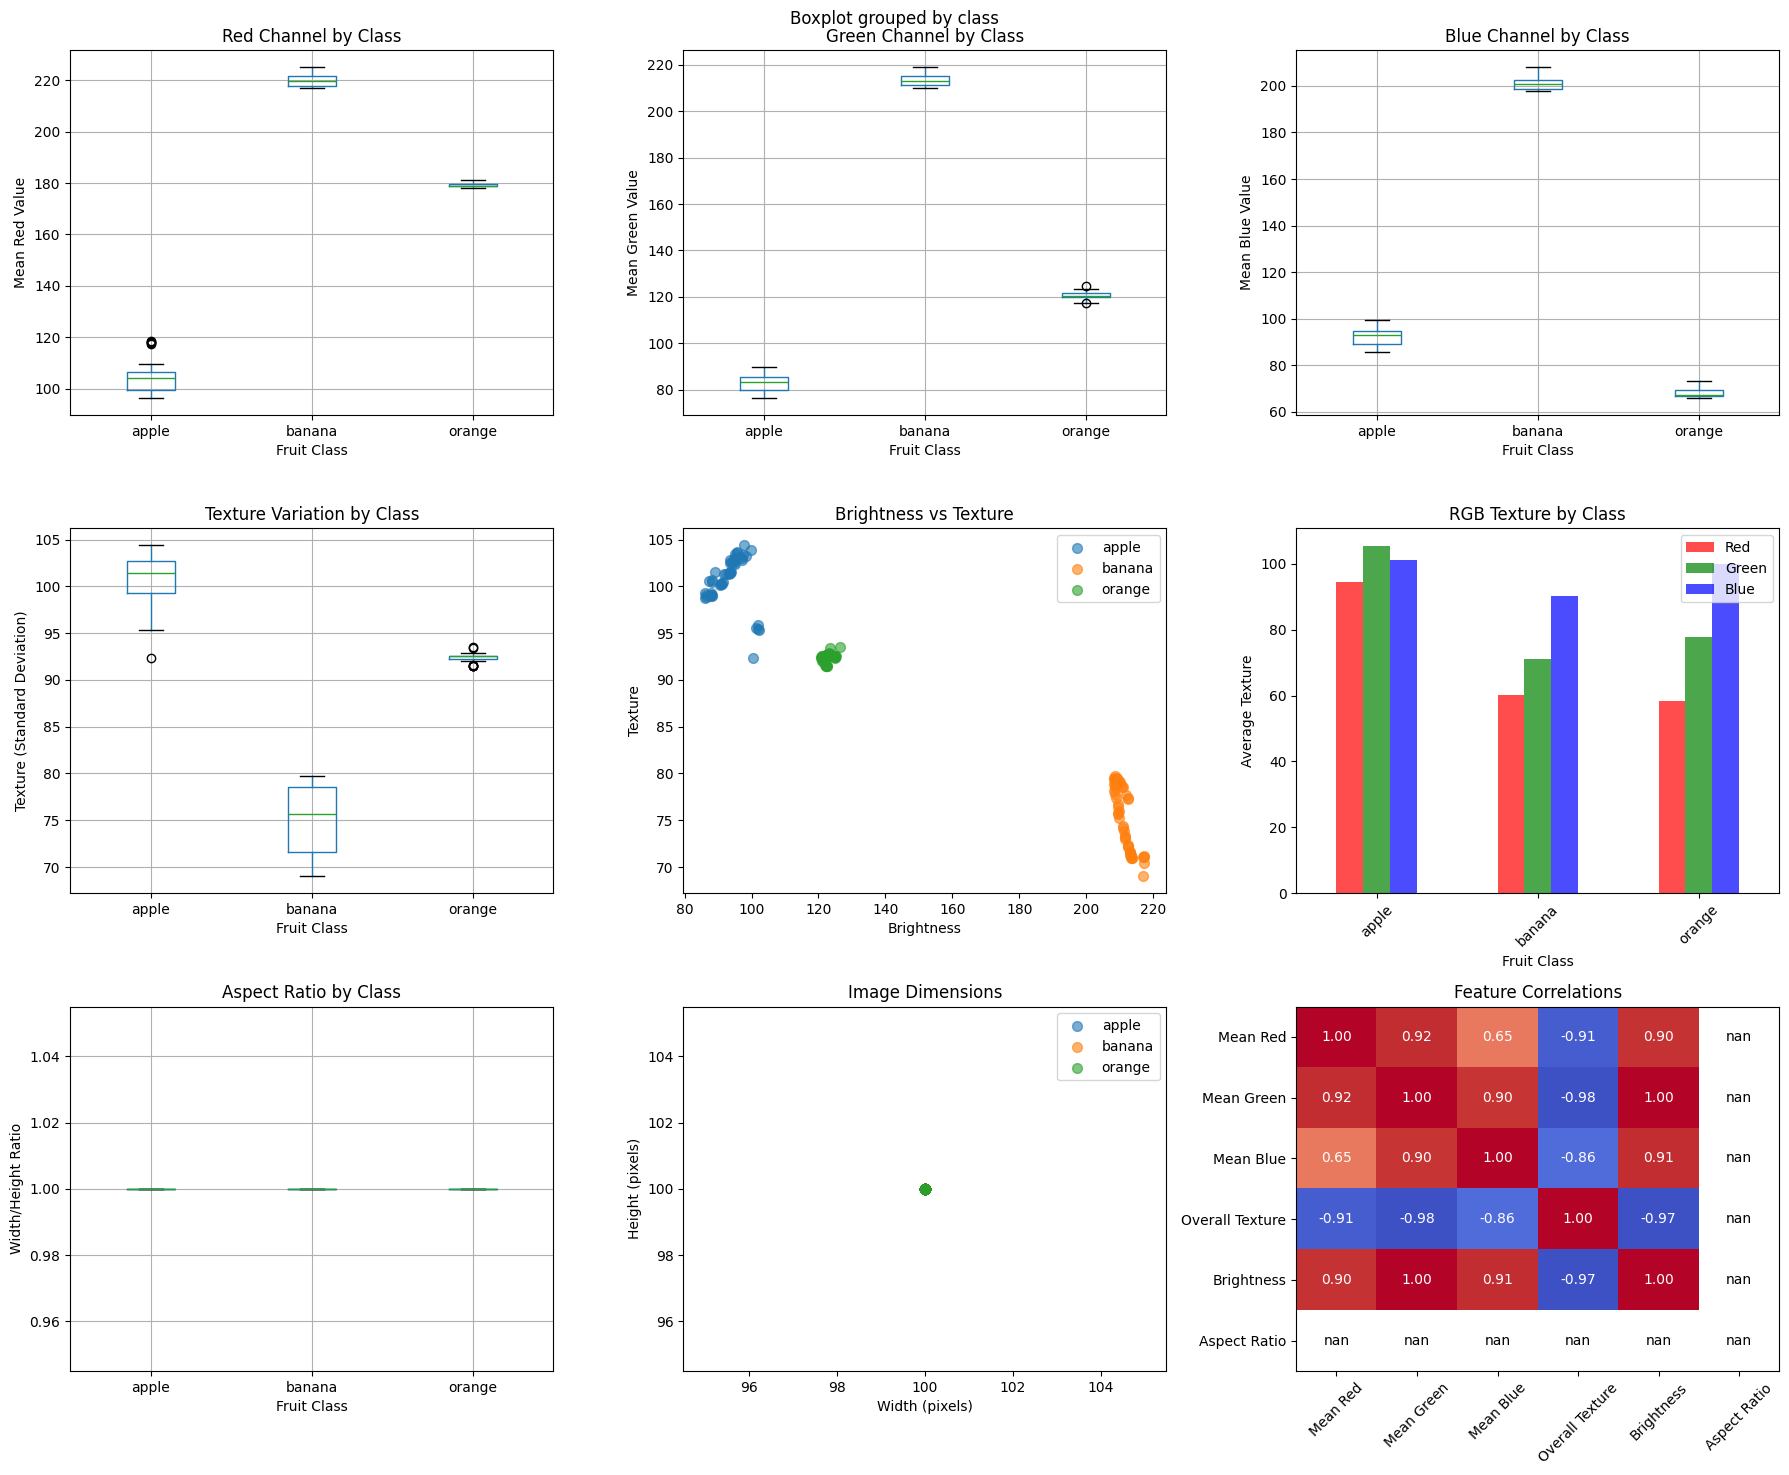

In [15]:
def visualize_feature_analysis(df):
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('🔍 Three Key Features Analysis', fontsize=16, fontweight='bold')

    color_channels = ['mean_red', 'mean_green', 'mean_blue']
    colors = ['red', 'green', 'blue']
    
    for i, (channel, color) in enumerate(zip(color_channels, colors)):
        df.boxplot(column=channel, by='class', ax=axes[0, i])
        axes[0, i].set_title(f'{color.title()} Channel by Class')
        axes[0, i].set_xlabel('Fruit Class')
        axes[0, i].set_ylabel(f'Mean {color.title()} Value')

    df.boxplot(column='overall_texture', by='class', ax=axes[1, 0])
    axes[1, 0].set_title('Texture Variation by Class')
    axes[1, 0].set_xlabel('Fruit Class')
    axes[1, 0].set_ylabel('Texture (Standard Deviation)')

    for class_name in df['class'].unique():
        class_data = df[df['class'] == class_name]
        axes[1, 1].scatter(class_data['brightness'], class_data['overall_texture'], 
                          label=class_name, alpha=0.6, s=50)
    axes[1, 1].set_xlabel('Brightness')
    axes[1, 1].set_ylabel('Texture')
    axes[1, 1].set_title('Brightness vs Texture')
    axes[1, 1].legend()

    texture_cols = ['texture_red', 'texture_green', 'texture_blue']
    class_texture_means = df.groupby('class')[texture_cols].mean()
    class_texture_means.plot(kind='bar', ax=axes[1, 2], color=['red', 'green', 'blue'], alpha=0.7)
    axes[1, 2].set_title('RGB Texture by Class')
    axes[1, 2].set_xlabel('Fruit Class')
    axes[1, 2].set_ylabel('Average Texture')
    axes[1, 2].legend(['Red', 'Green', 'Blue'])
    axes[1, 2].tick_params(axis='x', rotation=45)
    

    df.boxplot(column='aspect_ratio', by='class', ax=axes[2, 0])
    axes[2, 0].set_title('Aspect Ratio by Class')
    axes[2, 0].set_xlabel('Fruit Class')
    axes[2, 0].set_ylabel('Width/Height Ratio')

    for class_name in df['class'].unique():
        class_data = df[df['class'] == class_name]
        axes[2, 1].scatter(class_data['width'], class_data['height'], 
                          label=class_name, alpha=0.6, s=50)
    axes[2, 1].set_xlabel('Width (pixels)')
    axes[2, 1].set_ylabel('Height (pixels)')
    axes[2, 1].set_title('Image Dimensions')
    axes[2, 1].legend()

    numeric_cols = ['mean_red', 'mean_green', 'mean_blue', 'overall_texture', 'brightness', 'aspect_ratio']
    correlation_matrix = df[numeric_cols].corr()
    
    im = axes[2, 2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2, 2].set_xticks(range(len(numeric_cols)))
    axes[2, 2].set_yticks(range(len(numeric_cols)))
    axes[2, 2].set_xticklabels([col.replace('_', ' ').title() for col in numeric_cols], rotation=45)
    axes[2, 2].set_yticklabels([col.replace('_', ' ').title() for col in numeric_cols])
    axes[2, 2].set_title('Feature Correlations')

    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            axes[2, 2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", 
                           color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black")
    
    plt.tight_layout()
    plt.show()

visualize_feature_analysis(feature_df)

Feature interpretation story

In [16]:
def interpret_features_story(df):

    print("📖 FEATURE INTERPRETATION STORY")
    print("=" * 60)
    
    # === STORY 1: COLOR SIGNATURES ===
    print("🎨 STORY 1: COLOR SIGNATURES - How Fruits Show Their Identity")
    print("-" * 60)
    
    color_analysis = df.groupby('class')[['mean_red', 'mean_green', 'mean_blue']].mean()
    
    print("Each fruit type has a unique color fingerprint:")
    for fruit in color_analysis.index:
        red, green, blue = color_analysis.loc[fruit]
        if red > green and red > blue:
            dominant = "Red-dominant"
            interpretation = "indicating warm, ripe characteristics"
        elif green > red and green > blue:
            dominant = "Green-dominant"
            interpretation = "showing fresh, natural coloring"
        elif blue > red and blue > green:
            dominant = "Blue-dominant"
            interpretation = "displaying cooler color tones"
        else:
            dominant = "Balanced color"
            interpretation = "having mixed color characteristics"
        
        color_strength = max(red, green, blue) - min(red, green, blue)
        color_intensity = "strong" if color_strength > 30 else "subtle"
        
        print(f"  🍎 {fruit.title()}: {dominant} with {color_intensity} color contrast")
        print(f"      RGB({red:.1f}, {green:.1f}, {blue:.1f}) - {interpretation}")

    print(f"\n🔍 STORY 2: TEXTURE PATTERNS - Surface Characteristics Tell a Tale")
    print("-" * 60)
    
    texture_analysis = df.groupby('class')['overall_texture'].agg(['mean', 'std'])
    
    print("Texture reveals surface properties and helps distinguish similar-colored fruits:")
    
    for fruit in texture_analysis.index:
        texture_mean = texture_analysis.loc[fruit, 'mean']
        texture_std = texture_analysis.loc[fruit, 'std']
        
        if texture_mean > 40:
            texture_desc = "highly textured"
            meaning = "rough or varied surface patterns"
        elif texture_mean > 25:
            texture_desc = "moderately textured"
            meaning = "some surface variation"
        else:
            texture_desc = "smooth"
            meaning = "uniform surface appearance"
        
        consistency = "consistent" if texture_std < 5 else "variable"
        
        print(f"  🔍 {fruit.title()}: {texture_desc} surface ({texture_mean:.1f}±{texture_std:.1f})")
        print(f"      This suggests {meaning} with {consistency} patterns across samples")

    print(f"\n📐 STORY 3: SHAPE SIGNATURES - Geometric Properties Matter")
    print("-" * 60)
    
    shape_analysis = df.groupby('class')['aspect_ratio'].agg(['mean', 'std'])
    brightness_analysis = df.groupby('class')['brightness'].agg(['mean', 'std'])
    
    print("Shape and brightness work together to create distinctive profiles:")
    
    for fruit in shape_analysis.index:
        aspect_mean = shape_analysis.loc[fruit, 'mean']
        brightness_mean = brightness_analysis.loc[fruit, 'mean']
        
        if aspect_mean > 1.2:
            shape_desc = "tends to be wider than tall"
        elif aspect_mean < 0.8:
            shape_desc = "tends to be taller than wide"
        else:
            shape_desc = "has roughly square proportions"
        
        if brightness_mean > 150:
            brightness_desc = "bright appearance"
        elif brightness_mean > 100:
            brightness_desc = "moderate brightness"
        else:
            brightness_desc = "darker appearance"
        
        print(f"  📏 {fruit.title()}: {shape_desc} (ratio: {aspect_mean:.2f})")
        print(f"      Combined with {brightness_desc} ({brightness_mean:.1f})")
    
    print(f"\n🔮 COMBINED FEATURE INSIGHTS")
    print("-" * 60)
    print("These three feature categories work synergistically:")
    print("  🎨 Color signatures provide the primary visual identity")
    print("  🔍 Texture patterns help distinguish fruits with similar colors")
    print("  📐 Shape characteristics add geometric discriminative power")
    
    return color_analysis, texture_analysis, shape_analysis

color_story, texture_story, shape_story = interpret_features_story(feature_df)

📖 FEATURE INTERPRETATION STORY
🎨 STORY 1: COLOR SIGNATURES - How Fruits Show Their Identity
------------------------------------------------------------
Each fruit type has a unique color fingerprint:
  🍎 Apple: Red-dominant with subtle color contrast
      RGB(104.4, 82.9, 92.7) - indicating warm, ripe characteristics
  🍎 Banana: Red-dominant with subtle color contrast
      RGB(219.9, 213.2, 201.1) - indicating warm, ripe characteristics
  🍎 Orange: Red-dominant with strong color contrast
      RGB(179.4, 120.8, 68.1) - indicating warm, ripe characteristics

🔍 STORY 2: TEXTURE PATTERNS - Surface Characteristics Tell a Tale
------------------------------------------------------------
Texture reveals surface properties and helps distinguish similar-colored fruits:
  🔍 Apple: highly textured surface (100.8±2.6)
      This suggests rough or varied surface patterns with consistent patterns across samples
  🔍 Banana: highly textured surface (75.2±3.4)
      This suggests rough or varied su

Model training and comparison

🤖 COMPARING MULTIPLE MODELS

🔄 Training Random Forest...
  📊 Train Accuracy: 1.0000
  📊 Test Accuracy: 1.0000
  📊 CV Score: 1.0000 (±0.0000)

🔄 Training SVM...
  📊 Train Accuracy: 1.0000
  📊 Test Accuracy: 1.0000
  📊 CV Score: 1.0000 (±0.0000)

🔄 Training K-Nearest Neighbors...
  📊 Train Accuracy: 1.0000
  📊 Test Accuracy: 1.0000
  📊 CV Score: 1.0000 (±0.0000)


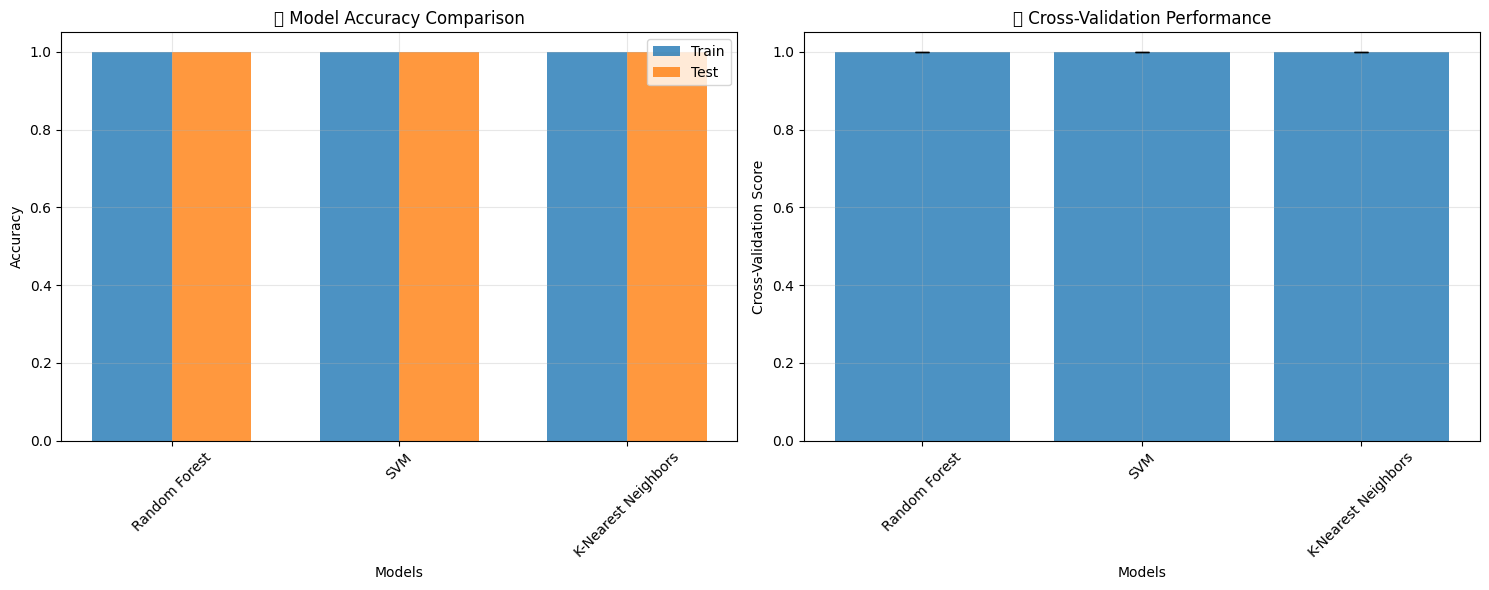


🏆 Best Model: Random Forest
📊 Best Test Accuracy: 1.0000


In [17]:
def compare_multiple_models(X_train, y_train, X_test, y_test, class_names):
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    print("🤖 COMPARING MULTIPLE MODELS")
    print("=" * 50)
    
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")

        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        
        results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_predictions': test_pred
        }
        
        print(f"  📊 Train Accuracy: {train_acc:.4f}")
        print(f"  📊 Test Accuracy: {test_acc:.4f}")
        print(f"  📊 CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    model_names = list(results.keys())
    train_accs = [results[name]['train_accuracy'] for name in model_names]
    test_accs = [results[name]['test_accuracy'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    axes[0].bar(x - width/2, train_accs, width, label='Train', alpha=0.8)
    axes[0].bar(x + width/2, test_accs, width, label='Test', alpha=0.8)
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('🎯 Model Accuracy Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    cv_means = [results[name]['cv_mean'] for name in model_names]
    cv_stds = [results[name]['cv_std'] for name in model_names]
    
    axes[1].bar(model_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.8)
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Cross-Validation Score')
    axes[1].set_title('📈 Cross-Validation Performance')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    best_model_name = max(model_names, key=lambda x: results[x]['test_accuracy'])
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"📊 Best Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
    
    return results, best_model_name

model_results, best_model_name = compare_multiple_models(X_train, y_train_enc, X_test, y_test_enc, le.classes_)

Detailed evaluation

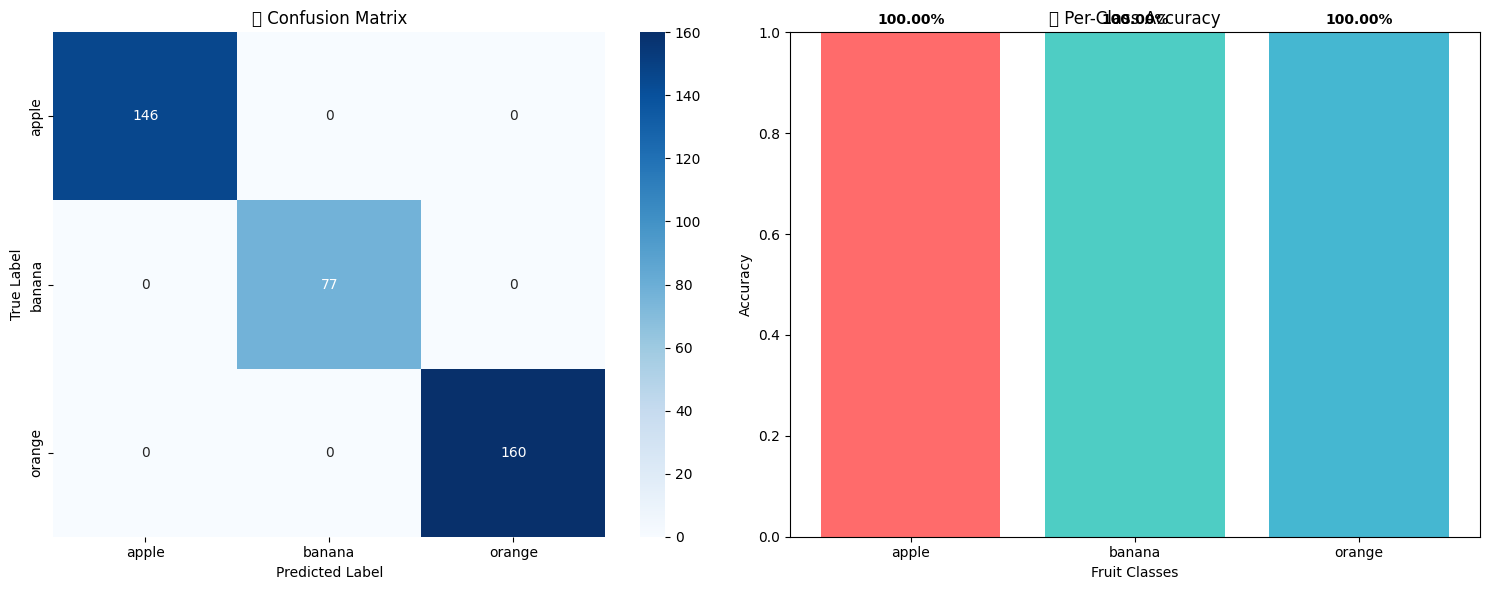

📊 DETAILED PERFORMANCE METRICS
Overall Accuracy: 1.0000

Per-class Performance:
  Apple: 100.00%
  Banana: 100.00%
  Orange: 100.00%

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       146
      banana       1.00      1.00      1.00        77
      orange       1.00      1.00      1.00       160

    accuracy                           1.00       383
   macro avg       1.00      1.00      1.00       383
weighted avg       1.00      1.00      1.00       383



In [18]:
def create_detailed_evaluation(y_true, y_pred, class_names):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('🔥 Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    class_accuracies = []
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = np.sum(cm[i, :])
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accuracies.append(class_accuracy)
    
    bars = axes[1].bar(class_names, class_accuracies, 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1].set_title('📊 Per-Class Accuracy')
    axes[1].set_xlabel('Fruit Classes')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0, 1)

    for bar, acc in zip(bars, class_accuracies):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print("📊 DETAILED PERFORMANCE METRICS")
    print("=" * 50)
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"\nPer-class Performance:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name.title()}: {class_accuracies[i]:.2%}")
    
    return cm, class_accuracies

best_model = model_results[best_model_name]['model']
y_pred = model_results[best_model_name]['test_predictions']

cm, class_accs = create_detailed_evaluation(y_test_enc, y_pred, le.classes_)

print("\n📋 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Save the best model

In [19]:
os.makedirs('../models', exist_ok=True)

model_path = '../models/fruit_classifier.pkl'
joblib.dump((best_model, le), model_path)

print("💾 BEST MODEL SAVED")
print("=" * 30)
print(f"Model Type: {best_model_name}")
print(f"Saved to: {model_path}")
print(f"Test Accuracy: {model_results[best_model_name]['test_accuracy']:.4f}")
print(f"Classes: {list(le.classes_)}")
print(f"Features: {len(X_train[0])} (64x64x3 flattened)")

best_model_path = '../models/best_fruit_classifier.pkl'
joblib.dump((best_model, le), best_model_path)
print(f"Also saved as: {best_model_path}")

💾 BEST MODEL SAVED
Model Type: Random Forest
Saved to: ../models/fruit_classifier.pkl
Test Accuracy: 1.0000
Classes: [np.str_('apple'), np.str_('banana'), np.str_('orange')]
Features: 12288 (64x64x3 flattened)
Also saved as: ../models/best_fruit_classifier.pkl


Demonstration of prediction function

In [20]:
def find_test_image():
    """Find a test image for demonstration"""
    for class_name in le.classes_:
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                return os.path.join(class_path, images[0])
    return None

test_image_path = find_test_image()
if test_image_path:
    print(f"\n🔮 TESTING PREDICTION FUNCTION")
    print("=" * 40)

    predicted_class, confidence, probabilities = predict_image(test_image_path, best_model, le)
    
    print(f"Test image: {test_image_path}")
    print(f"Predicted class: {predicted_class}")
    
    if confidence is not None:
        print(f"Confidence: {confidence:.2%}")
        print("\nAll class probabilities:")
        for i, class_name in enumerate(le.classes_):
            print(f"  {class_name}: {probabilities[i]:.2%}")


🔮 TESTING PREDICTION FUNCTION
Test image: ../data/test\apple\r0_103_100.jpg
Predicted class: apple
Confidence: 100.00%

All class probabilities:
  apple: 100.00%
  banana: 0.00%
  orange: 0.00%


Sample images display


🖼️  DISPLAYING SAMPLE IMAGES


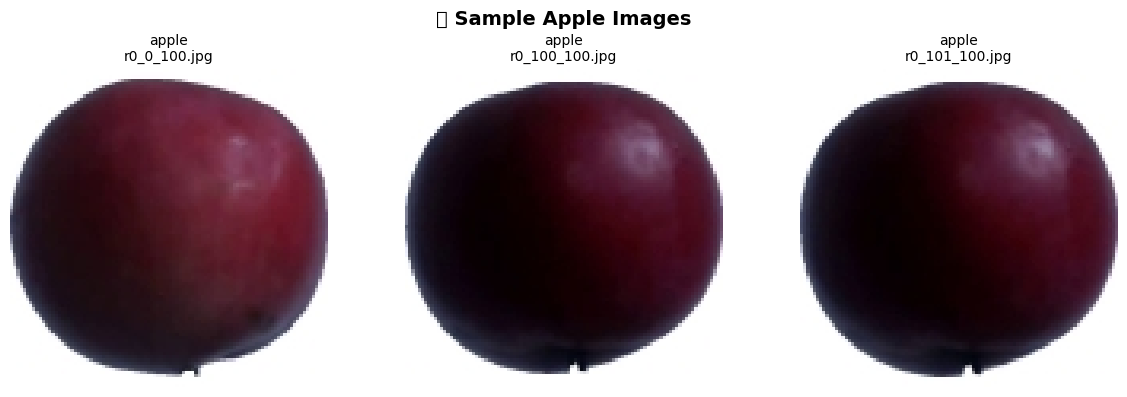

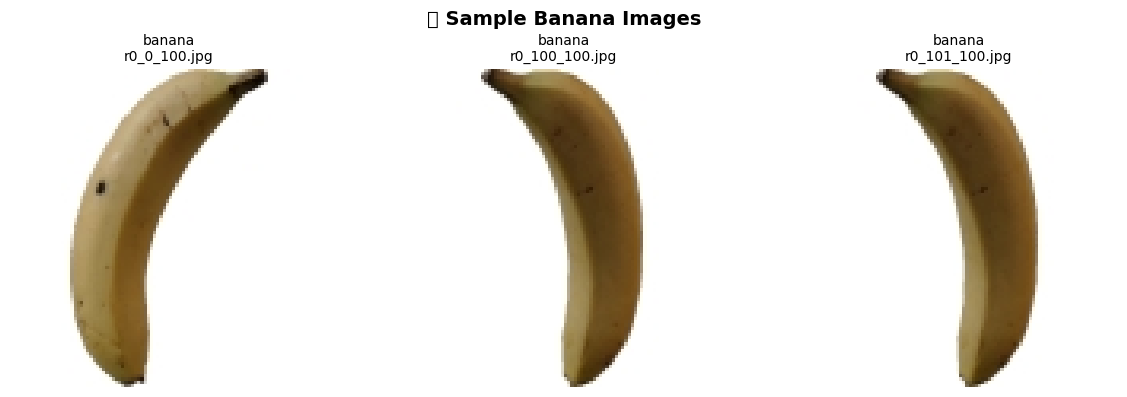

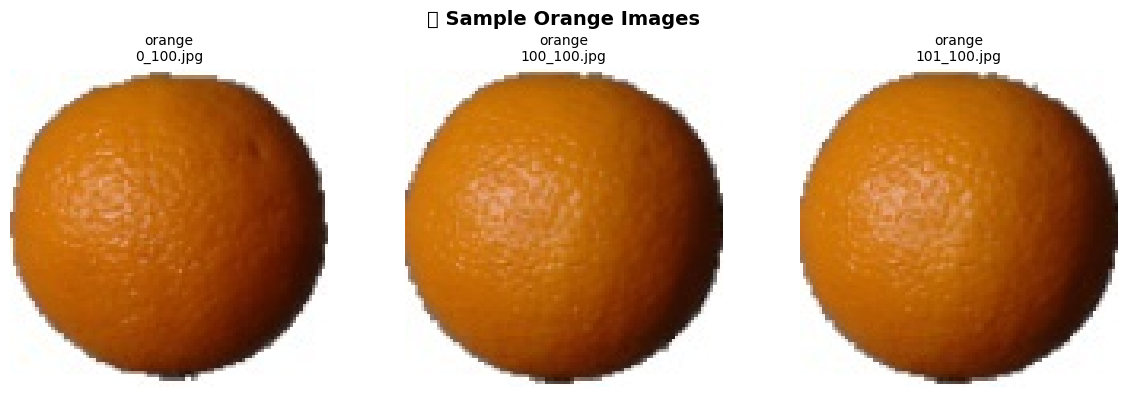

In [21]:
print(f"\n🖼️  DISPLAYING SAMPLE IMAGES")
print("=" * 40)
show_sample_images(train_dir, le.classes_, n=3)